# Transfer Learning from Time Series to Images

In this notebook, we will explore the application of transfer learning techniques to classify time series data by converting them into image-like representations. We will utilize pre-trained convolutional neural networks (CNNs) to extract features from these images and fine-tune the models for our specific classification task.

At the end of this notebook, you will have a trained model capable of classifying time series data based on their image representations using transfer learning.

The tasks its to implement the following steps:
1. Convert time series data into image-like matrices (e.g., recurrence plots).
2. Create a custom PyTorch dataset to load the images and labels.
3. Implement transfer learning using a pre-trained CNN (e.g., ResNet).
4. Train the model on the training dataset and validate it on the validation dataset.

The itens 3 and 4 should be done by you.

In [1]:
# Core utilities
import os
import re
import zipfile
import time
from pathlib import Path

# Data handling
import numpy as np
import pandas as pd
import requests
from tqdm import tqdm

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning helpers
from pyts.image import RecurrencePlot
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.metrics import ConfusionMatrixDisplay

plt.style.use("default")
sns.set_palette("husl")

## Download Data (Colab)

Using the Colab environment, we can download the dataset directly from a provided URL. The dataset contains time series data that we will later convert into image-like representations for our classification task.

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# # Define the URL of the zip file
# zip_file_url = "https://drive.google.com/uc?export=download&id=1fQdEogfDxmPU3Fo5j42uP68WQpQzXfU9"

# # Define the destination directory in your mounted Google Drive
# # Make sure this path exists and is where you want to save the unzipped files
# destination_directory = "/content/drive/MyDrive/Itirapina/guigues/features/features/rgb/features/rgb"

# # Create the destination directory if it doesn't exist
# !mkdir -p {destination_directory}

# # Define the path to save the downloaded zip file
# download_path = f"{destination_directory}/data.zip"

# # Use wget to download the zip file
# # The 'uc?export=download&id=' part is a common way to get a direct download link for GDrive files
# print(f"Downloading {zip_file_url} to {download_path}...")
# !wget --no-check-certificate '{zip_file_url}' -O '{download_path}'

# # Unzip the downloaded file into the destination directory
# print(f"\nUnzipping {download_path} to {destination_directory}...")
# !unzip -o '{download_path}' -d '{destination_directory}'

# print("\nDownload and extraction complete!")

## Download Data (Personal Computer)

Using a personal computer, download the dataset from the provided Google Drive link and extract it to your working directory.

In [3]:
# Windows-friendly download + unzip (no Colab, no shell commands)
# Change destination_directory if you prefer another folder on your machine
destination_directory = Path.home() / "Downloads" / "Itirapina" / "guigues" / "features" / "features" / "rgb" / "features" / "rgb"
destination_directory.mkdir(parents=True, exist_ok=True)

zip_file_url = "https://drive.google.com/uc?export=download&id=1fQdEogfDxmPU3Fo5j42uP68WQpQzXfU9"
download_path = destination_directory / "data.zip"

print(f"Downloading {zip_file_url} to {download_path} ...")
with requests.get(zip_file_url, stream=True, allow_redirects=True) as r:
    r.raise_for_status()
    total = int(r.headers.get("content-length", 0))
    with open(download_path, "wb") as f, tqdm(total=total, unit="B", unit_scale=True, desc="Downloading", ncols=80) as pbar:
        for chunk in r.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)
                pbar.update(len(chunk))

print(f"Extracting {download_path} to {destination_directory} ...")
with zipfile.ZipFile(download_path, "r") as zf:
    zf.extractall(destination_directory)

print("Download and extraction complete!")


Downloading: 100%|█████████████████████████| 3.99M/3.99M [00:01<00:00, 2.71MB/s]


Extracting C:\Users\stiva\Downloads\Itirapina\guigues\features\features\rgb\features\rgb\data.zip to C:\Users\stiva\Downloads\Itirapina\guigues\features\features\rgb\features\rgb ...
Download and extraction complete!


## Load Spectral Data
Read the plant spectra stored as text files, preprocess them, and split into training, validation, and test sets.

In [4]:
def load_spectral_data(directory):
    data_path = Path(directory)
    files = sorted(data_path.glob("*.txt"))
    if not files:
        raise FileNotFoundError(f"No .txt files found in {directory}")
    frames = []
    for file in files:
        frame = pd.read_csv(
            file, sep=r'\s+',
            header=None, engine="python"
        )
        frame["filename"] = file.name
        frames.append(frame)
    return pd.concat(frames, ignore_index=True)

df = load_spectral_data(destination_directory / "features" / "rgb")
print(f"Loaded {len(df)} samples from {df['filename'].nunique()} files")
print(f"Dataset shape: {df.shape}")
df.head()

Loaded 34788 samples from 858 files
Dataset shape: (34788, 40)


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,filename
0,0.351145,0.335821,0.346154,0.329630,0.351145,0.339901,0.298450,0.304878,0.308370,0.312500,...,0.295652,0.293447,0.294766,0.296188,0.307317,0.299451,0.281726,2266,A.tomentosum,A.tomentosum_11-06-B.txt
1,0.356589,0.340909,0.352459,0.324232,0.329966,0.293860,0.294545,0.293436,0.302521,0.293436,...,0.289641,0.289417,0.288066,0.296296,0.314775,0.300000,0.291525,2284,A.tomentosum,A.tomentosum_11-06-B.txt
2,0.347619,0.331579,0.344186,0.339583,0.317895,0.347518,0.303030,0.299603,0.305164,0.301741,...,0.306931,0.308151,0.303605,0.300412,0.307692,0.320072,0.304425,2285,A.tomentosum,A.tomentosum_11-06-B.txt
3,0.343374,0.329897,0.351351,0.347594,0.342391,0.335463,0.302594,0.311111,0.309904,0.313218,...,0.309932,0.302752,0.296099,0.302521,0.300211,0.313589,0.295302,2297,A.tomentosum,A.tomentosum_11-06-B.txt
4,0.341880,0.320988,0.326829,0.343313,0.327511,0.338272,0.305804,0.299335,0.302083,0.303030,...,0.311637,0.319608,0.317554,0.317422,0.309693,0.331384,0.321364,2311,A.tomentosum,A.tomentosum_11-06-B.txt


## Parse Species Info
Parse the species information from the filenames. In this way, we can assign labels to each spectrum.

In [5]:
def extract_species_and_channel(filename):
    base_name = filename.replace('.txt', '')
    if '-' in base_name:
        channel = base_name.split('-')[-1]
    else:
        channel = base_name[-1]
    if '.' in base_name:
        species_part = base_name.split('.', 1)[1]
        if '_' in species_part:
            species = species_part.split('_')[0]
        elif '-' in species_part:
            species = species_part.split('-')[0]
        else:
            species = species_part
    else:
        species = 'unknown'
    return species, channel

From the filenames, we can extract the species names and create a mapping from species names to integer labels. This will allow us to convert the species information into numerical labels that can be used for training the model.

In [6]:
df[["species", "channel"]] = df["filename"].apply(lambda name: pd.Series(extract_species_and_channel(name)))

Each channel of the image will correspond to a different spectral band. In this case, we will use only the red, green and blue channels, which correspond to specific wavelength ranges in the visible spectrum. So we create one

In [7]:
df_red = df[df['channel'] == 'R'].copy()
df_green = df[df['channel'] == 'G'].copy()
df_blue = df[df['channel'] == 'B'].copy()

Looking for the distribution of classes in the training set to compute balanced class weights for the loss function. Also, split the dataset to be balanced across classes.

In [8]:
print(f"After filtering to Green channel: {len(df_green)} samples")
print(f"Number of species: {df_green['species'].nunique()}")
print(df_green['species'].value_counts().head())

After filtering to Green channel: 11596 samples
Number of species: 6
species
brasiliensis    4498
rubiginosa      2535
torta           2197
tomentosum      1248
ramiflora        650
Name: count, dtype: int64


Define the minimum amount of samples per class to be included in the dataset.

In [9]:
amount_samples_per_class = min(df_green['species'].value_counts().head().values)

Realize the slice of min_samples_per_class to filter out classes with too few samples. Now we can create the datasets and dataloaders for training, validation, and testing.

In [10]:
n = int(amount_samples_per_class)

def _sample_group(g):
    # deterministically take the first n rows; if the group is smaller, repeat from the start
    if len(g) >= n:
        return g.iloc[:n]
    reps = n // len(g)
    rem = n % len(g)
    parts = [g] * reps
    if rem:
        parts.append(g.iloc[:rem])
    return pd.concat(parts, ignore_index=False)

df_green = df_green.groupby("species", group_keys=False).apply(_sample_group).reset_index(drop=True)
df_green = df_green.sample(frac=1.0, random_state=42).reset_index(drop=True)

df_red = df_red.groupby("species", group_keys=False).apply(_sample_group).reset_index(drop=True)
df_red = df_red.sample(frac=1.0, random_state=42).reset_index(drop=True)

df_blue = df_blue.groupby("species", group_keys=False).apply(_sample_group).reset_index(drop=True)
df_blue = df_blue.sample(frac=1.0, random_state=42).reset_index(drop=True)


print(f"Balanced df_green -> {n} samples per class")
print(df_green["species"].value_counts().sort_index())

Balanced df_green -> 650 samples per class
species
brasiliensis    650
guianensis      650
ramiflora       650
rubiginosa      650
tomentosum      650
torta           650
Name: count, dtype: int64


C:\Users\stiva\AppData\Local\Temp\ipykernel_28272\705013820.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_green = df_green.groupby("species", group_keys=False).apply(_sample_group).reset_index(drop=True)
C:\Users\stiva\AppData\Local\Temp\ipykernel_28272\705013820.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_red = df_red.groupby("species", group_keys=False).apply(_sample_group).reset_ind

In [11]:
# select spectral feature columns (0..34)
feature_cols = [col for col in df_green.columns if isinstance(col, int) and 0 <= col <= 34]

# extract per-channel matrices
X_green = df_green[feature_cols].values
X_red = df_red[feature_cols].values
X_blue = df_blue[feature_cols].values

# ensure same number of rows per channel
if not (X_green.shape[0] == X_red.shape[0] == X_blue.shape[0]):
    raise ValueError("Row counts differ between channels; cannot concatenate along axis=1")

# build a label encoder from the union of species across channels (robust)
label_encoder = LabelEncoder()
all_species = np.unique(np.concatenate([df_green['species'].values, df_red['species'].values, df_blue['species'].values]))
label_encoder.fit(all_species)

# transform labels (use green labels as the canonical y since rows align)
y = label_encoder.transform(df_green['species'].values)
num_classes = len(label_encoder.classes_)

# concatenate features horizontally (axis=1)
X = np.stack([X_red, X_green, X_blue], axis=1)

print(f"Number of spectral features per channel: {len(feature_cols)}")
print(f"Concatenated feature length (3 channels): {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")
print(f"Classes: {dict(enumerate(label_encoder.classes_))}")
print(f"Number of classes: {num_classes}")

Number of spectral features per channel: 35
Concatenated feature length (3 channels): 3
Number of samples: 3900
Classes: {0: 'brasiliensis', 1: 'guianensis', 2: 'ramiflora', 3: 'rubiginosa', 4: 'tomentosum', 5: 'torta'}
Number of classes: 6


## Split and Resample
Define the train, validation, and test splits. Create balanced class weights for the loss function. Also, realize the interpolation inside the time series.
In this way, all times series from 35 times steps will be resized to 140 time steps. Producing images of size 140x140.
How we have 3 bands (RGB), the final image size will be 3x140x140.

In [12]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

orig_len = X_train.shape[-1]
new_len = orig_len * 4
orig_x = np.arange(orig_len)
new_x = np.linspace(0, orig_len - 1, new_len)

def interpolate_matrix(X_values, orig_axis, new_axis):
    """
    Interpolate X_values along the time axis.
    Accepts X_values shaped (B, 3, T) and returns (B, 3, new_T).
    Also supports (B, T) input for backwards compatibility.
    """
    X_values = X_values.astype(float)
    orig_axis = np.asarray(orig_axis)
    new_axis = np.asarray(new_axis)

    if X_values.ndim == 2:
        # (B, T) -> (B, new_T)
        B, T = X_values.shape
        if orig_axis.size != T:
            raise ValueError(f"orig_axis length ({orig_axis.size}) != T ({T})")
        X_new = np.empty((B, new_axis.size), dtype=float)
        for i in range(B):
            X_new[i, :] = np.interp(new_axis, orig_axis, X_values[i, :])
        return X_new

    elif X_values.ndim == 3:
        # (B, C, T) -> (B, C, new_T)
        B, C, T = X_values.shape
        if orig_axis.size != T:
            raise ValueError(f"orig_axis length ({orig_axis.size}) != T ({T})")
        flat = X_values.reshape(-1, T)                     # (B*C, T)
        flat_new = np.empty((flat.shape[0], new_axis.size), dtype=float)
        for i in range(flat.shape[0]):
            flat_new[i, :] = np.interp(new_axis, orig_axis, flat[i, :])
        return flat_new.reshape(B, C, new_axis.size)

    else:
        raise ValueError("Unexpected X_values ndim; expected 2 or 3 dimensions")

X_train = interpolate_matrix(X_train, orig_x, new_x)
X_val = interpolate_matrix(X_val, orig_x, new_x)
X_test = interpolate_matrix(X_test, orig_x, new_x)
feature_cols = list(range(new_len))

print(f"Interpolated feature length: {new_len}")
print(f"Train/Val/Test shapes: {X_train.shape}, {X_val.shape}, {X_test.shape}")

Interpolated feature length: 140
Train/Val/Test shapes: (2340, 3, 140), (780, 3, 140), (780, 3, 140)


## Data Normalization

Normalizing the data using the stand deviation to produce a distribution with mean=0 and variation=1

In [13]:
# Min-max normalize X_train, X_val, X_test using training-set statistics (per-channel, per-timepoint)
eps = 1e-8

# ensure float
X_train = X_train.astype(float)
X_val = X_val.astype(float)
X_test = X_test.astype(float)

# compute per-timepoint, per-channel min/max from training set -> shape (1, C, T)
train_mins = X_train.min(axis=0, keepdims=True)
train_maxs = X_train.max(axis=0, keepdims=True)
train_range = np.maximum(train_maxs - train_mins, eps)

# apply min-max normalization and clip to [0, 1]
X_train = np.clip((X_train - train_mins) / train_range, 0.0, 1.0)
X_val   = np.clip((X_val   - train_mins) / train_range, 0.0, 1.0)
X_test  = np.clip((X_test  - train_mins) / train_range, 0.0, 1.0)

print("After min-max normalization using training-set statistics:")
print("  X_train shape:", X_train.shape, "min:", X_train.min().round(6), "max:", X_train.max().round(6))
print("  X_val   shape:", X_val.shape,   "min:", X_val.min().round(6),   "max:", X_val.max().round(6))
print("  X_test  shape:", X_test.shape,  "min:", X_test.min().round(6),  "max:", X_test.max().round(6))

After min-max normalization using training-set statistics:
  X_train shape: (2340, 3, 140) min: 0.0 max: 1.0
  X_val   shape: (780, 3, 140) min: 0.0 max: 1.0
  X_test  shape: (780, 3, 140) min: 0.0 max: 1.0


## Visualise Means
After the interpolation, we can visualise the mean spectra for each class to see how they look like.
For each dataset (train, val, test), we compute the mean spectra for each class and plot them.

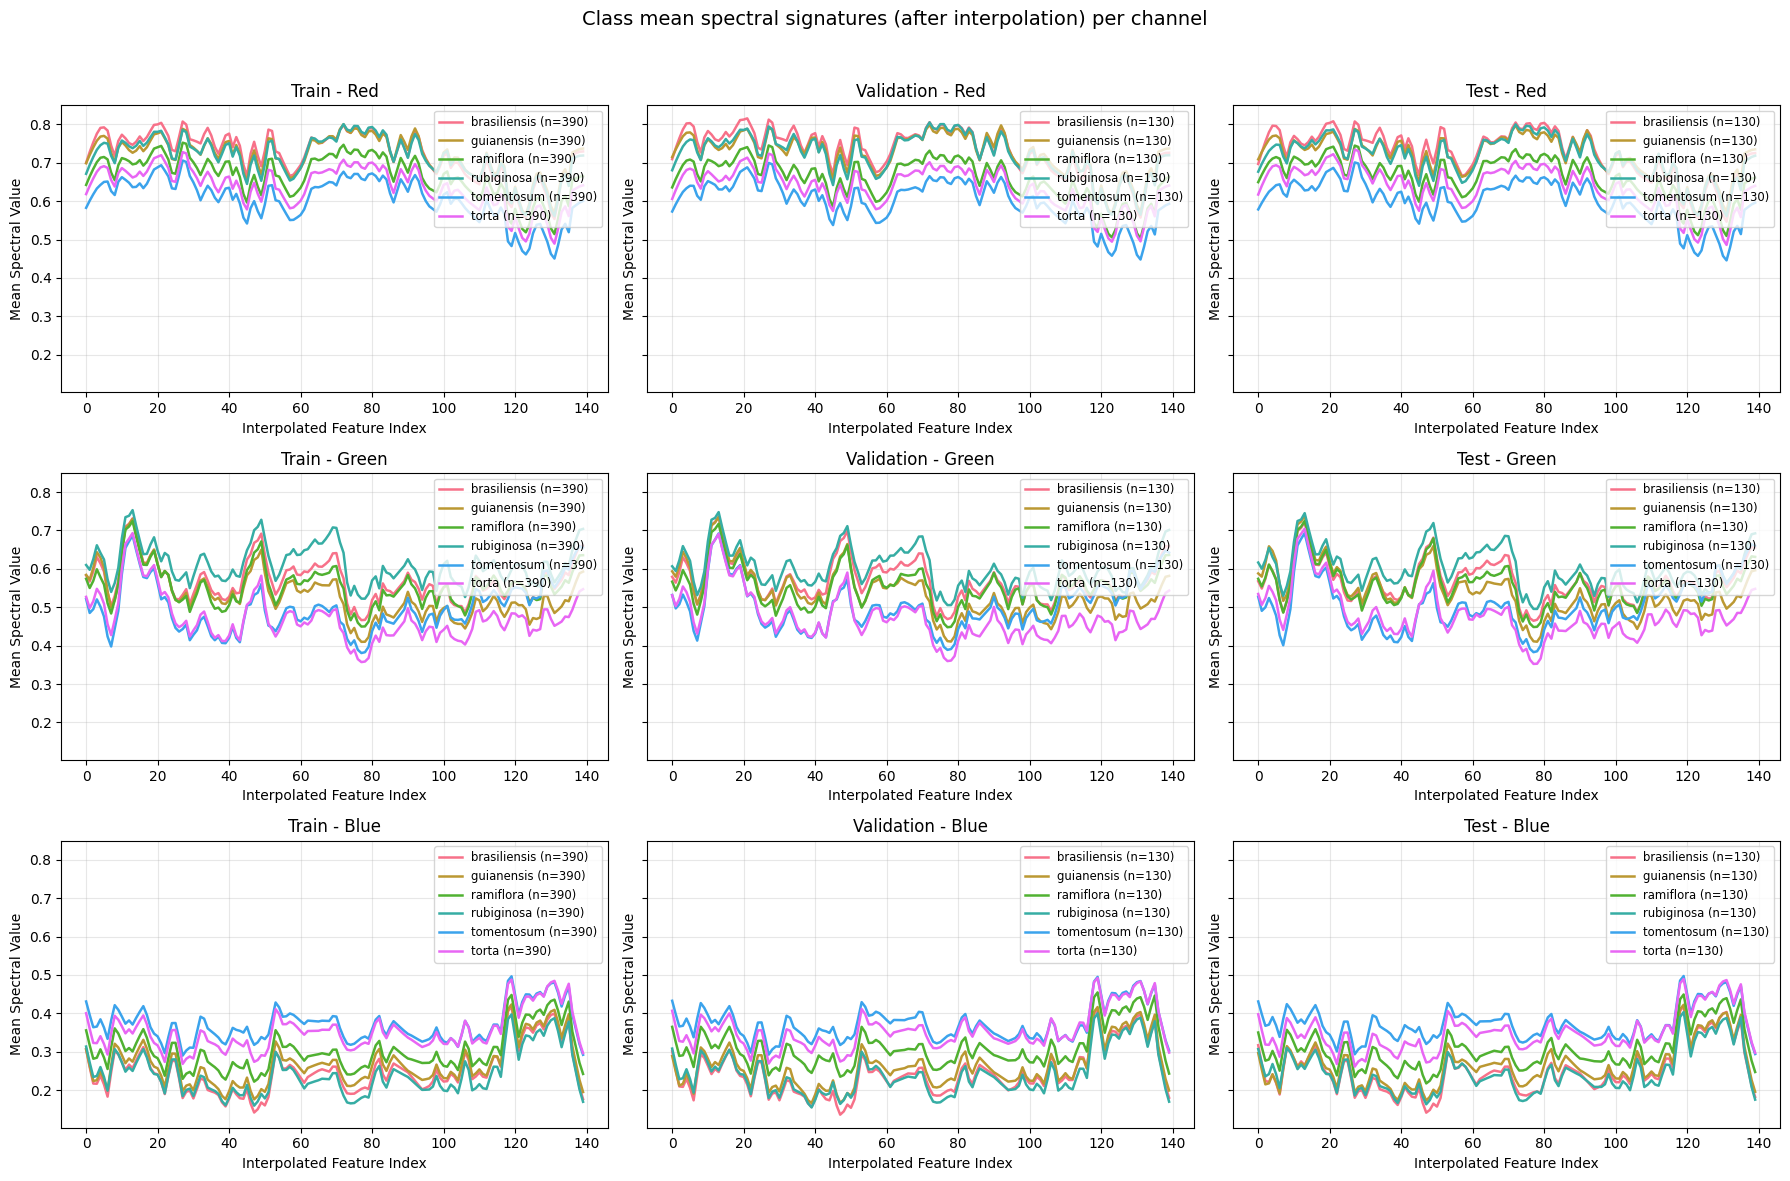

In [14]:
def plot_dataset_class_means(ax, X_values, labels, encoder, max_classes=None):
    unique_labels = np.unique(labels)
    if max_classes is not None:
        unique_labels = unique_labels[:max_classes]
    palette = sns.color_palette("husl", len(unique_labels))
    x_axis = np.arange(X_values.shape[1])
    for color, lbl in zip(palette, unique_labels):
        mask = labels == lbl
        if mask.sum() == 0:
            continue
        mean_curve = X_values[mask].mean(axis=0)
        ax.plot(x_axis, mean_curve, label=f"{encoder.classes_[lbl]} (n={mask.sum()})", color=color, linewidth=1.8)
    ax.set_xlabel("Interpolated Feature Index")
    ax.set_ylabel("Mean Spectral Value")
    ax.grid(alpha=0.3)
    ax.legend(loc="upper right", fontsize="small")

channels = ["Red", "Green", "Blue"]
fig, axes = plt.subplots(len(channels), 3, figsize=(18, 12), sharey=True)

for ch_idx, ch_name in enumerate(channels):
    plot_dataset_class_means(axes[ch_idx, 0], X_train[:, ch_idx, :], y_train, label_encoder)
    axes[ch_idx, 0].set_title(f"Train - {ch_name}")
    plot_dataset_class_means(axes[ch_idx, 1], X_val[:, ch_idx, :], y_val, label_encoder)
    axes[ch_idx, 1].set_title(f"Validation - {ch_name}")
    plot_dataset_class_means(axes[ch_idx, 2], X_test[:, ch_idx, :], y_test, label_encoder)
    axes[ch_idx, 2].set_title(f"Test - {ch_name}")

fig.suptitle("Class mean spectral signatures (after interpolation) per channel", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

The interpolation does not changed the behavior of each class, keeping similar among the datasets

## Recurrence Plots
A recurrence plot (RP) is a two-dimensional graph that visualizes the recurring states of a dynamical system or time series data. It is a powerful tool for analyzing complex, nonlinear data, especially short or non-stationary time series where other methods may fail.
We convert each time series into a recurrence plot image, which captures the temporal patterns and relationships within the data. This transformation allows us to leverage pre-trained vision models for classification tasks.
We create recurrence plots for each spectrum in the dataset. Each recurrence plot is generated by computing the pairwise distances between time points in the time series and applying a threshold to determine recurrence.
The recurrence plots are 140x140 pixels once the time series have 140 time steps after interpolation.
We can visualise some examples of recurrence plots for different classes to see how they look like.

Recurrence plot shapes -> train: (2340, 3, 140, 140), val: (780, 3, 140, 140), test: (780, 3, 140, 140)


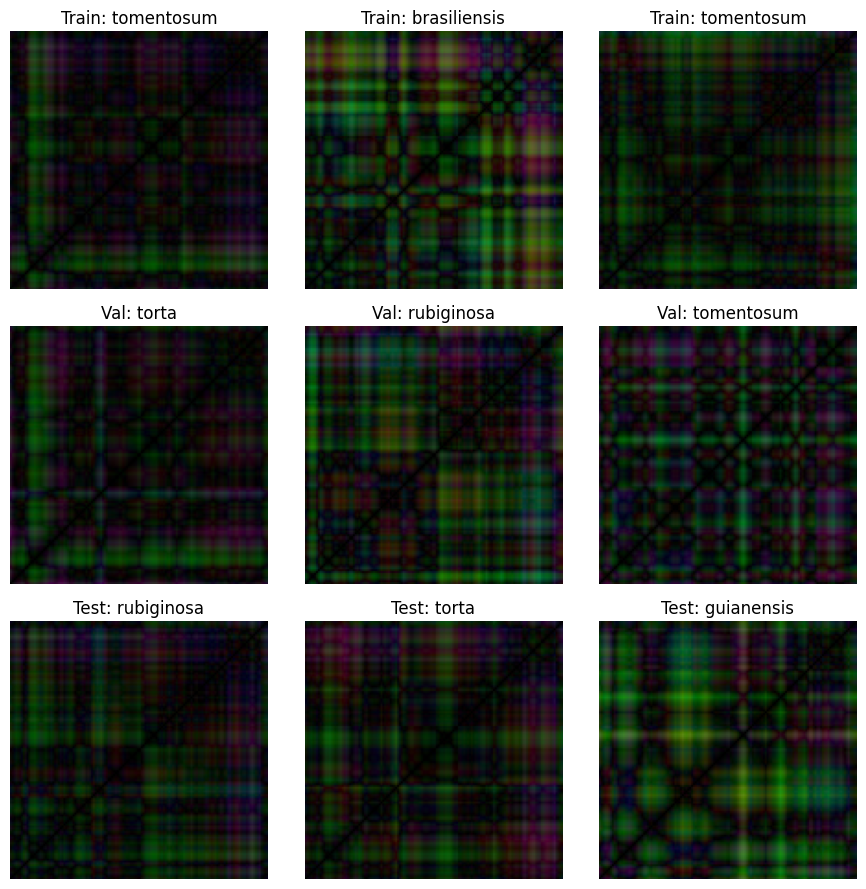

In [15]:
rp = RecurrencePlot(threshold=None)
# compute recurrence plots per-channel and then average channels into a single grayscale image
train_rps, val_rps, test_rps = [], [], []
for ch in range(X_train.shape[1]):  # iterate over channel dimension (axis=1)
    X_train_c = X_train[:, ch, :]  # (B, T)
    X_val_c = X_val[:, ch, :]
    X_test_c = X_test[:, ch, :]

    X_train_rp_c = rp.fit_transform(X_train_c)
    X_val_rp_c = rp.transform(X_val_c)
    X_test_rp_c = rp.transform(X_test_c)

    train_rps.append(X_train_rp_c)
    val_rps.append(X_val_rp_c)
    test_rps.append(X_test_rp_c)

# stack -> (B, C, H, W) then collapse channels by mean -> (B, H, W)
X_train_rp = np.stack(train_rps, axis=1)
X_val_rp = np.stack(val_rps, axis=1)
X_test_rp = np.stack(test_rps, axis=1)

print(f"Recurrence plot shapes -> train: {X_train_rp.shape}, val: {X_val_rp.shape}, test: {X_test_rp.shape}")

n_show = min(3, X_train_rp.shape[0], X_val_rp.shape[0], X_test_rp.shape[0])
fig, axes = plt.subplots(3, n_show, figsize=(n_show * 3, 9))
for idx in range(n_show):
    axes[0, idx].imshow((X_train_rp[idx].swapaxes(0, 2)*255).astype(np.uint8), origin='lower')
    axes[0, idx].set_title(f"Train: {label_encoder.classes_[y_train[idx]]}")
    axes[0, idx].axis('off')
    axes[1, idx].imshow((X_val_rp[idx].swapaxes(0, 2)*255).astype(np.uint8), origin='lower')
    axes[1, idx].set_title(f"Val: {label_encoder.classes_[y_val[idx]]}")
    axes[1, idx].axis('off')
    axes[2, idx].imshow((X_test_rp[idx].swapaxes(0, 2)*255).astype(np.uint8), origin='lower')
    axes[2, idx].set_title(f"Test: {label_encoder.classes_[y_test[idx]]}")
    axes[2, idx].axis('off')
plt.tight_layout()
plt.show()

## Torch Dataset
Create a custom PyTorch dataset to load the recurrence plot images and their corresponding labels. This dataset will be used to feed data into the model during training and evaluation.
The images are stored as numpy arrays, and the labels are stored as integers. The dataset will handle loading the images and labels, as well as any necessary transformations.

In [16]:
class NumpyImageDataset(Dataset):
    """Prepares recurrence plots once so __getitem__ stays lightweight.
    Expects X shaped (B, C, H, W). Keeps original size unless target_size is given.
    """

    def __init__(self, X, y, target_size=None):
        # X: numpy array (B, C, H, W) -> convert to float tensor
        X_tensor = torch.from_numpy(X).float()  # (B, C, H, W)

        # normalize per-sample per-channel over H,W
        mins = X_tensor.amin(dim=(2, 3), keepdim=True)
        maxs = X_tensor.amax(dim=(2, 3), keepdim=True).clamp(min=1e-6)
        X_tensor = (X_tensor - mins) / (maxs - mins)

        # optionally resize (keeps shape if target_size is None or matches current)
        if target_size is not None and (X_tensor.shape[2], X_tensor.shape[3]) != tuple(target_size):
            X_tensor = F.interpolate(X_tensor, size=target_size, mode='bilinear', align_corners=False)

        self.images = X_tensor.contiguous()  # (B, C, H, W)
        self.labels = torch.from_numpy(y).long()

    def __len__(self):
        return self.labels.numel()

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

batch_size = 32
train_ds = NumpyImageDataset(X_train_rp, y_train)
val_ds = NumpyImageDataset(X_val_rp, y_val)
test_ds = NumpyImageDataset(X_test_rp, y_test)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Evaluation Methods

To evaluate the model's performance, we will use accuracy as the primary metric. Accuracy measures the proportion of correctly classified samples out of the total number of samples.
Also, the F1-score will be used to provide a more comprehensive evaluation, especially in cases of class imbalance. The F1-score is the harmonic mean of precision and recall, providing a balance between the two metrics.
And a confusion matrix will be generated to visualize the model's performance across different classes. The confusion matrix shows the number of correct and incorrect predictions for each class, allowing us to identify specific areas where the model may be struggling.

In [17]:
def evaluate_and_plot(model, best_state, test_loader):
    if best_state is not None:
        model.load_state_dict({key: value.to(device) for key, value in best_state.items()})
    model.eval()
    test_preds, test_labels_list = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            test_preds.extend(preds.cpu().numpy())
            test_labels_list.extend(labels.cpu().numpy())

    test_acc = accuracy_score(test_labels_list, test_preds)
    cm = confusion_matrix(test_labels_list, test_preds)
    precision = precision_score(test_labels_list, test_preds, average='weighted', zero_division=0)
    recall = recall_score(test_labels_list, test_preds, average='weighted', zero_division=0)
    f1 = f1_score(test_labels_list, test_preds, average='weighted', zero_division=0)

    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted):    {recall:.4f}")
    print(f"F1-score (weighted):  {f1:.4f}")
    print(f"Test accuracy: {test_acc:.4f}")

    # Plot absolute counts and row-normalized percentages side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # Absolute counts
    disp_counts = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp_counts.plot(cmap='Blues', ax=axes[0], xticks_rotation=45, values_format='d')
    axes[0].set_title("Confusion Matrix — counts")

    # Row-normalized percentages
    cm_row_sums = cm.sum(axis=1, keepdims=True)
    with np.errstate(divide='ignore', invalid='ignore'):
        cm_pct = (cm.astype(float) / cm_row_sums) * 100
    cm_pct = np.nan_to_num(cm_pct)  # replace NaNs resulting from zero rows

    disp_pct = ConfusionMatrixDisplay(confusion_matrix=cm_pct, display_labels=label_encoder.classes_)
    # draw heatmap only (no values) so our percent annotations do not overlap
    disp_pct.plot(cmap='Blues', ax=axes[1], xticks_rotation=45, values_format=None, include_values=False)
    axes[1].set_title("Confusion Matrix — row %")

    # Annotate percentage cells with one decimal and a % sign
    for i in range(cm_pct.shape[0]):
        for j in range(cm_pct.shape[1]):
            axes[1].text(j, i, f"{cm_pct[i, j]:.1f}%", ha='center', va='center', color='black', fontsize=8)

    plt.tight_layout()
    plt.show()

## Training Lines
The code below produces a plot for compare the acc and loss of the trainind and validation datasets

In [18]:
def plot_training_curves(list_train_loss, list_val_loss, list_train_acc, list_val_acc):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Left subplot: Training and Validation Loss
    axes[0].plot(list_train_loss, label='Train Loss')
    axes[0].plot(list_val_loss, label='Val Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Right subplot: Training and Validation Accuracy
    axes[1].plot(list_train_acc, label='Train Accuracy')
    axes[1].plot(list_val_acc, label='Val Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

## Train ResNet Head

This cell provide the method train_model, will train the model layers that require gradients are True.
In this case, only the head of the ResNet model when the transfer learning is used.
The training will be done for a number of epochs, using the training and validation dataloaders.


In [19]:
def train_model(model, train_loader, val_loader, num_epochs):
    # compute balanced class weights from training set
    class_counts = np.bincount(y_train, minlength=num_classes)
    print("Train class counts:", dict(enumerate(class_counts)))
    class_weights = (y_train.size) / (num_classes * class_counts.astype(float))
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float, device=device)

    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    # optimize any parameters that require gradients (e.g. the new fc)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

    list_train_loss = []
    list_val_loss = []
    list_train_acc = []
    list_val_acc = []

    best_val_acc = 0.0
    best_state = None
    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        val_running_loss = 0
        running_corrects = 0
        val_running_corrects = 0
        total = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [train]", leave=False)
        for inputs, labels in pbar:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            running_corrects += (preds == labels).sum().item()
            total += inputs.size(0)
            pbar.set_postfix({"batch_loss": f"{loss.item():.4f}", "batch_acc": f"{(preds == labels).float().mean().item():.4f}"})
        pbar.close()
        train_loss = running_loss / total
        train_acc = running_corrects / total
        list_train_loss.append(train_loss)
        list_train_acc.append(train_acc)

        model.eval()
        val_preds, val_labels = [], []
        
        with torch.no_grad():
            val_running_loss = 0.0
            val_running_corrects = 0
            total_val = 0
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                val_loss = criterion(outputs, labels)
                val_running_loss += val_loss.item() * inputs.size(0)
                preds = outputs.argmax(dim=1)
                val_running_corrects += (preds == labels).sum().item()
                total_val += inputs.size(0)
            val_loss = val_running_loss / total_val
            val_acc = val_running_corrects / total_val

        list_val_acc.append(val_acc)
        list_val_loss.append(val_loss)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = {key: value.cpu() for key, value in model.state_dict().items()}
        print(f"Epoch {epoch}/{num_epochs} - train_loss {train_loss:.4f} - train_acc {train_acc:.4f} - val_acc {val_acc:.4f}")

    return best_state, list_train_loss, list_val_loss, list_train_acc, list_val_acc

## TO DO
- Implement the model to realize feature extraction from the images. (Transfer Learning)
- Create a Multi-Layer Perceptron (MLP) to be trained from scratch as Fully Connected (FC) layers of the model, or Head.

In [20]:
#### CODE TO CREATE THE MODEL WITH PRETRAINED WEIGHTS

#### CODE TO CHANGE / CREATE THE CLASSIFICATION LAYER

weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, num_classes)
)

model = model.to(device) # Sendto the device

num_epochs = 20 # Number of epochs to train


In [21]:
best_state, list_train_loss, list_val_loss, list_train_acc, list_val_acc = train_model(model, train_loader, val_loader, num_epochs)

Train class counts: {0: 390, 1: 390, 2: 390, 3: 390, 4: 390, 5: 390}


Epoch 1/20 - train_loss 1.7311 - train_acc 0.2632 - val_acc 0.3231


Epoch 2/20 - train_loss 1.5425 - train_acc 0.3932 - val_acc 0.3769


Epoch 3/20 - train_loss 1.3856 - train_acc 0.4709 - val_acc 0.3603


Epoch 4/20 - train_loss 1.2367 - train_acc 0.5338 - val_acc 0.3936


Epoch 5/20 - train_loss 1.1350 - train_acc 0.5726 - val_acc 0.3936


Epoch 6/20 - train_loss 1.0153 - train_acc 0.6252 - val_acc 0.3679


Epoch 7/20 - train_loss 0.9355 - train_acc 0.6624 - val_acc 0.3923


Epoch 8/20 - train_loss 0.8145 - train_acc 0.7179 - val_acc 0.3833


Epoch 9/20 - train_loss 0.7399 - train_acc 0.7457 - val_acc 0.3897


Epoch 10/20 - train_loss 0.6760 - train_acc 0.7577 - val_acc 0.4013


Epoch 11/20 - train_loss 0.6096 - train_acc 0.7897 - val_acc 0.3987


Epoch 12/20 - train_loss 0.5355 - train_acc 0.8261 - val_acc 0.3936


Epoch 13/20 - train_loss 0.4875 - train_acc 0.8282 - val_acc 0.3987


Epoch 14/20 - train_loss 0.4407 - train_acc 0.8551 - val_acc 0.3923


Epoch 15/20 - train_loss 0.3900 - train_acc 0.8774 - val_acc 0.3846


Epoch 16/20 - train_loss 0.3544 - train_acc 0.8846 - val_acc 0.3936


Epoch 17/20 - train_loss 0.3587 - train_acc 0.8855 - val_acc 0.3897


Epoch 18/20 - train_loss 0.3455 - train_acc 0.8910 - val_acc 0.4000


Epoch 19/20 - train_loss 0.2832 - train_acc 0.9175 - val_acc 0.4128


Epoch 20/20 - train_loss 0.2897 - train_acc 0.9103 - val_acc 0.4026


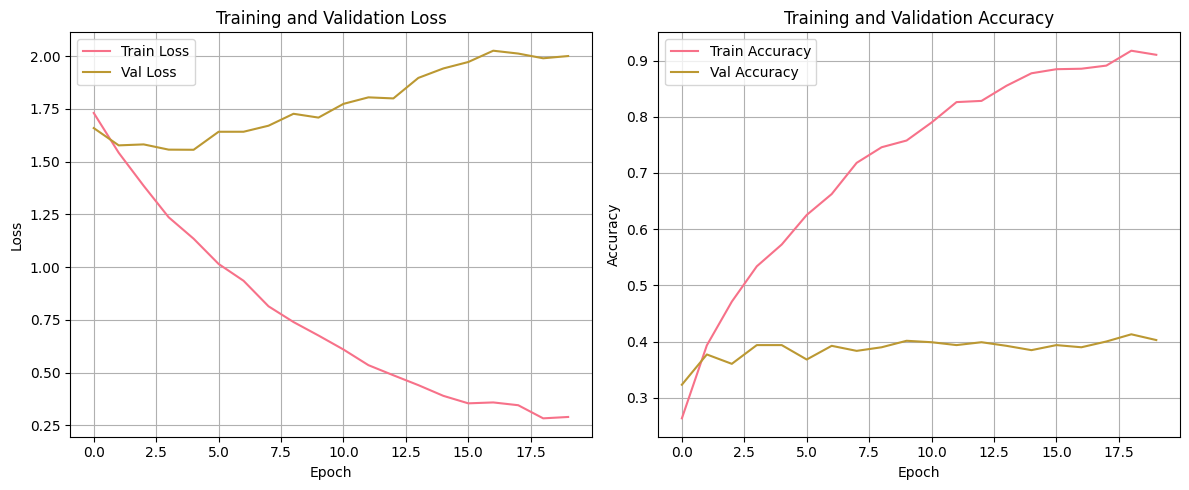

Precision (weighted): 0.4239
Recall (weighted):    0.4205
F1-score (weighted):  0.4197
Test accuracy: 0.4205


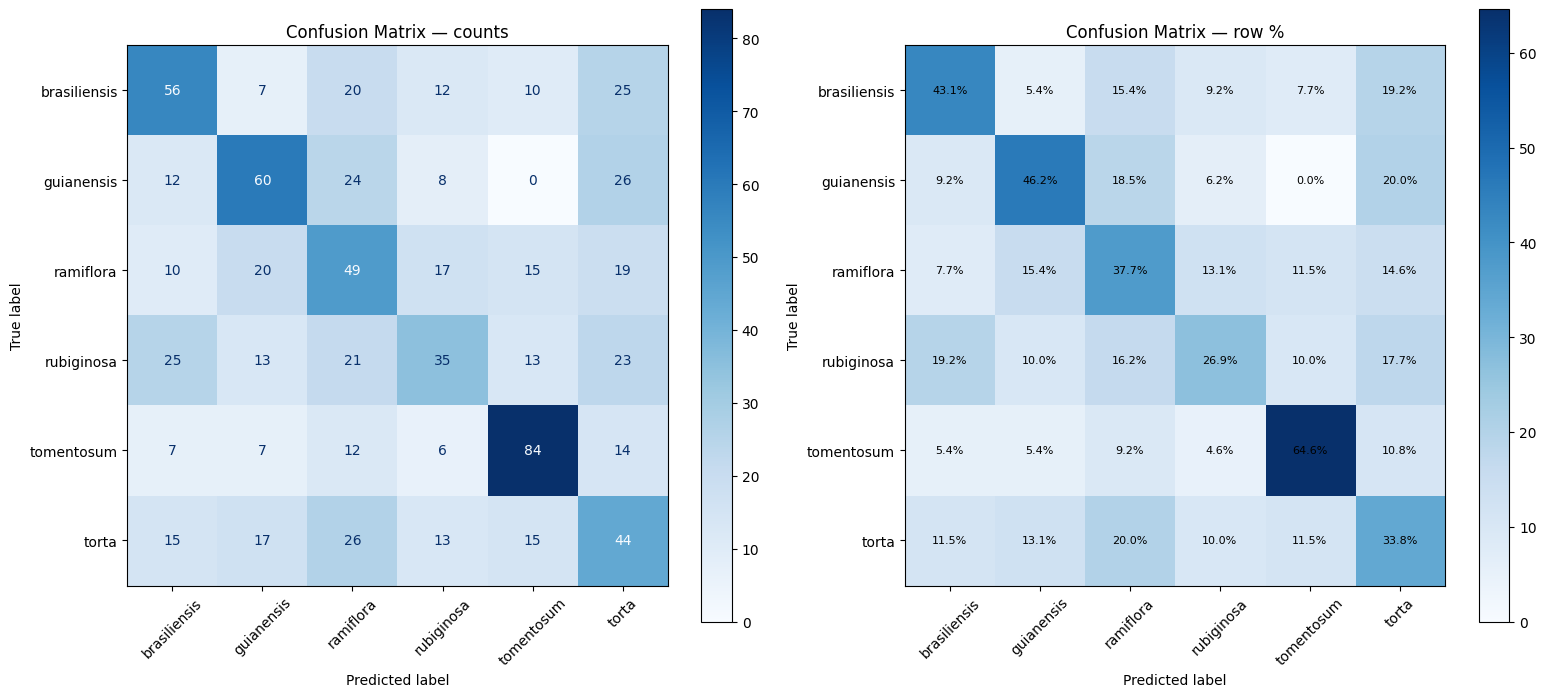

In [22]:
plot_training_curves(list_train_loss, list_val_loss, list_train_acc, list_val_acc)
evaluate_and_plot(model, best_state, test_loader)

## Fine-Tune Last Layers

Using the same model, we can unfreeze some of the last layers of the backbone to fine-tune them along with the head.
- Unfreeze the last few layers of the backbone for fine-tuning.
- Train the model with the unfrozen layers for a number of epochs.
- Evaluate the model on the test dataset and plot the results.

In [23]:
#### CODE TO CREATE THE MODEL WITH PRETRAINED WEIGHTS

#### CODE TO UNFREZZE SOME LAYERS OF THE MODEL

#### CODE TO CHANGE / CREATE THE CLASSIFICATION LAYER

weights = ResNet50_Weights.DEFAULT
model_ft = resnet50(weights=weights)
for param in model_ft.parameters():
    param.requires_grad = False
# Unfreeze last two layers
for param in model_ft.layer4.parameters():
    param.requires_grad = True
for param in model_ft.fc.parameters():
    param.requires_grad = True

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, num_classes)
)

model_ft = model_ft.to(device)

best_state, list_train_loss, list_val_losss, list_train_acc, list_val_acc = train_model(model_ft, train_loader, val_loader, num_epochs)

Train class counts: {0: 390, 1: 390, 2: 390, 3: 390, 4: 390, 5: 390}


Epoch 1/20 - train_loss 1.5227 - train_acc 0.3769 - val_acc 0.4846


Epoch 2/20 - train_loss 0.7548 - train_acc 0.7197 - val_acc 0.5205


Epoch 3/20 - train_loss 0.2494 - train_acc 0.9162 - val_acc 0.5667


Epoch 4/20 - train_loss 0.1210 - train_acc 0.9641 - val_acc 0.5897


Epoch 5/20 - train_loss 0.1052 - train_acc 0.9705 - val_acc 0.5577


Epoch 6/20 - train_loss 0.0605 - train_acc 0.9803 - val_acc 0.5833


Epoch 7/20 - train_loss 0.0693 - train_acc 0.9799 - val_acc 0.6244


Epoch 8/20 - train_loss 0.1049 - train_acc 0.9709 - val_acc 0.5718


Epoch 9/20 - train_loss 0.0971 - train_acc 0.9744 - val_acc 0.6077


Epoch 10/20 - train_loss 0.0979 - train_acc 0.9731 - val_acc 0.6026


Epoch 11/20 - train_loss 0.0546 - train_acc 0.9850 - val_acc 0.5974


Epoch 12/20 - train_loss 0.0462 - train_acc 0.9850 - val_acc 0.6103


Epoch 13/20 - train_loss 0.0333 - train_acc 0.9897 - val_acc 0.6154


Epoch 14/20 - train_loss 0.0444 - train_acc 0.9863 - val_acc 0.5897


Epoch 15/20 - train_loss 0.0114 - train_acc 0.9966 - val_acc 0.6231


Epoch 16/20 - train_loss 0.0250 - train_acc 0.9919 - val_acc 0.6051


Epoch 17/20 - train_loss 0.0124 - train_acc 0.9966 - val_acc 0.5936


Epoch 18/20 - train_loss 0.1083 - train_acc 0.9714 - val_acc 0.6038


Epoch 19/20 - train_loss 0.0632 - train_acc 0.9838 - val_acc 0.5936


Epoch 20/20 - train_loss 0.0330 - train_acc 0.9927 - val_acc 0.6051


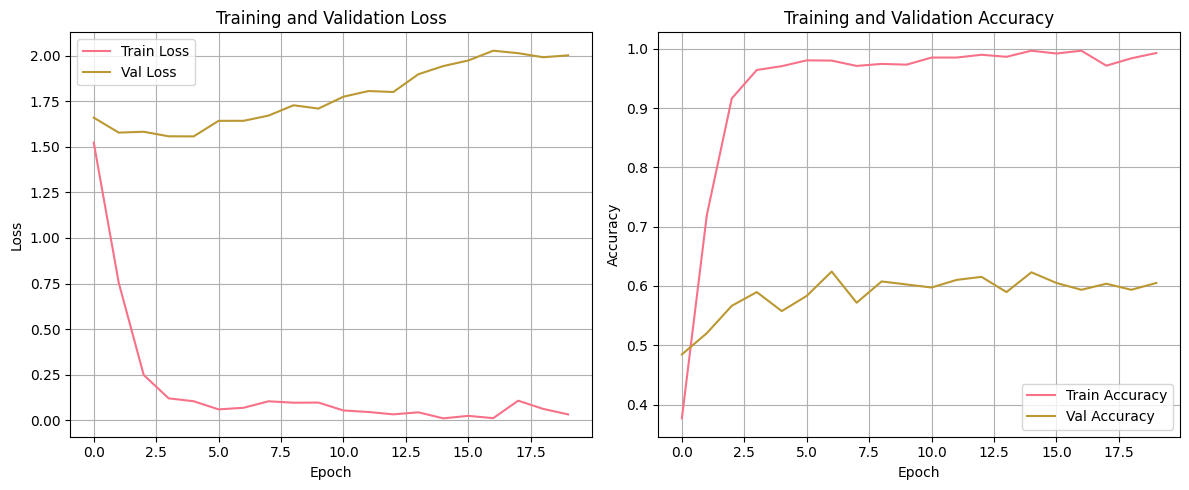

Precision (weighted): 0.6187
Recall (weighted):    0.6051
F1-score (weighted):  0.5957
Test accuracy: 0.6051


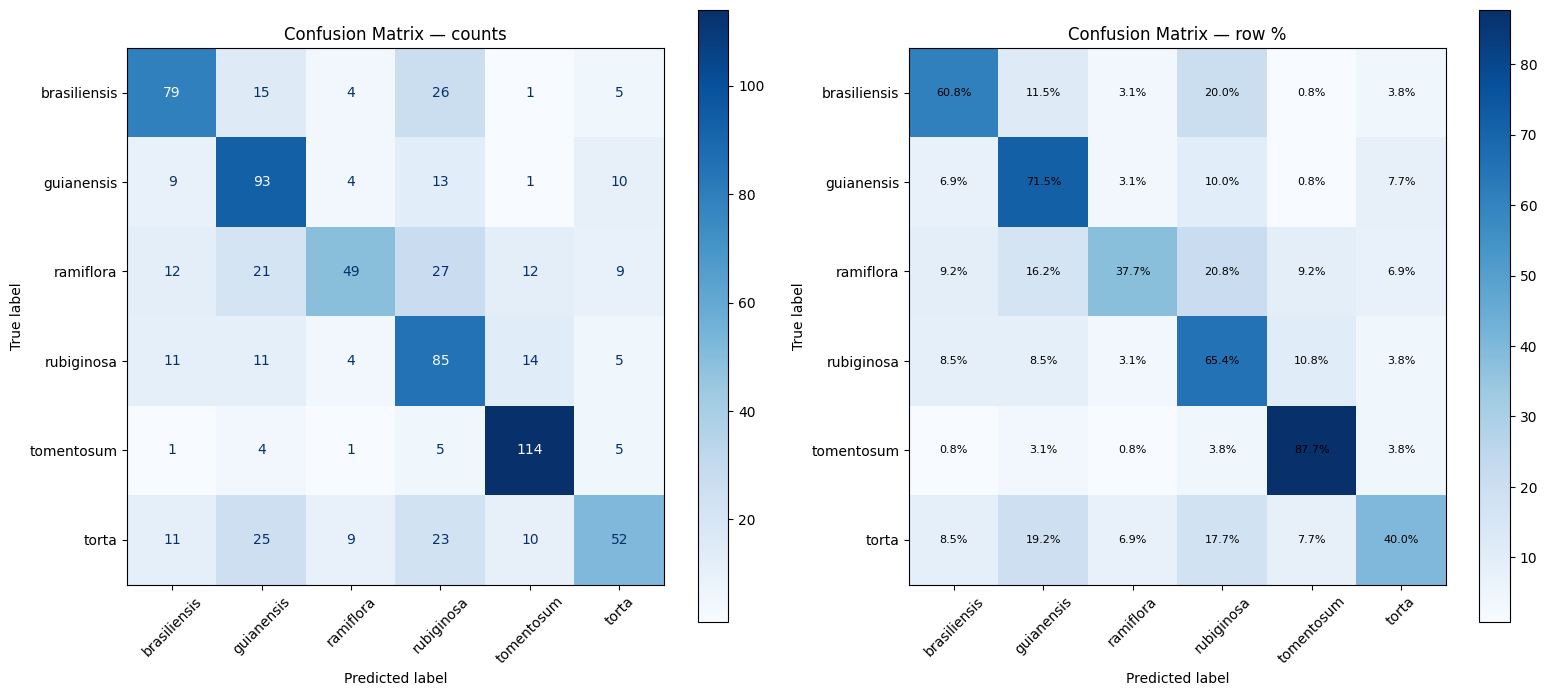

In [24]:
plot_training_curves(list_train_loss, list_val_loss, list_train_acc, list_val_acc)
evaluate_and_plot(model_ft, best_state, test_loader)